In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

In [2]:
def rk4(f, y0, h, start, stop):
    N = int(np.ceil((stop - start)/h))
    t = np.zeros(N+1)
    y = np.zeros((N+1,4))
    y[0] = y0
    t[0] = start
    for i in range(N):
        k1 = h*f(y[i])
        k2 = h*f(y[i] + k1/2)
        k3 = h*f(y[i] + k2/2)
        k4 = h*f(y[i] + k3)
        y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4)/6
        t[i+1] = t[i] + h
    return (t, y)

In [3]:
m = 1
l = 1
g = 9.81
def f(y):
    theta1 = y[0]
    theta2 = y[1]
    p1 = y[2]
    p2 = y[3]
    f1 = 6/(m*l**2)*(2*p1-3*np.cos(theta1-theta2)*p2)/(16-9*np.cos(theta1-theta2)**2)
    f2 = 6/(m*l**2)*(8*p2-3*np.cos(theta1-theta2)*p1)/(16-9*np.cos(theta1-theta2)**2)
    f3 = -0.5*m*l**2*(f1*f2*np.sin(theta1-theta2)+3*g/l*np.sin(theta1))
    f4 = -0.5*m*l**2*(-f1*f2*np.sin(theta1-theta2)+g/l*np.sin(theta2))
    return  np.array([f1, f2, f3, f4])

KeyError: 'ffmpeg'

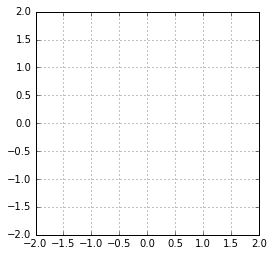

In [4]:
data = rk4(f, [np.pi/2, np.pi/2, 0, 0], 0.001, 0, 20)
fact = 20

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()
plt.gca().set_aspect('equal', adjustable='box')

line, = ax.plot([], [], 'r-', lw=3)
extremity, = ax.plot([], [], 'black', lw=1)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
x1 = l*np.sin(data[1][:,0])
y1 = -l*np.cos(data[1][:,0])
x2 = x1 + l*np.sin(data[1][:,1])
y2 = y1 - l*np.cos(data[1][:,1])

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    thisx = [0, x1[i*fact], x2[i*fact]]
    thisy = [0, y1[i*fact], y2[i*fact]]
    line.set_data(thisx, thisy)
    extremity.set_data(x2[:i*fact+1], y2[:i*fact+1])
    time_text.set_text(time_template % (data[0][i*fact]))
    return extremity, line, time_text

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(len(data[1])/fact), interval=20, blit=True)
#anim.save("double_pendulum.mp4", fps=fact*5/2)
HTML(anim.to_html5_video())

In [5]:
from sympy import Symbol, Function, Derivative, cos, latex, simplify
from sympy.calculus.euler import euler_equations
t = Symbol('t')
l = Symbol('l')
m = Symbol('m')
g = Symbol('g')
theta1 = Function('theta1')
theta2 = Function('theta2')
L = 1/6*m*l**2*((theta2(t).diff(t))**2 + 4*(theta1(t).diff(t))**2 + 3*theta1(t).diff(t)*theta2(t).diff(t)*cos(theta1(t) - theta2(t))) + 1/2*m*g*l*(3*cos(theta1(t)) + cos(theta2(t)))
eqs = euler_equations(L, [theta1(t), theta2(t)], t)
s_latex = repr(latex(eqs))
file = open("latex_eq.txt", "w")
file.write(s_latex)
file.close()

$$\left [ - 1.5 g l m \sin{\left (\theta_{1}{\left (t \right )} \right )} - \frac{1}{6} l^{2} m \left(- 3 \left(\frac{d}{d t} \theta_{1}{\left (t \right )} - \frac{d}{d t} \theta_{2}{\left (t \right )}\right) \sin{\left (\theta_{1}{\left (t \right )} - \theta_{2}{\left (t \right )} \right )} \frac{d}{d t} \theta_{2}{\left (t \right )} + 3 \cos{\left (\theta_{1}{\left (t \right )} - \theta_{2}{\left (t \right )} \right )} \frac{d^{2}}{d t^{2}}  \theta_{2}{\left (t \right )} + 8 \frac{d^{2}}{d t^{2}}  \theta_{1}{\left (t \right )}\right) - 0.5 l^{2} m \sin{\left (\theta_{1}{\left (t \right )} - \theta_{2}{\left (t \right )} \right )} \frac{d}{d t} \theta_{1}{\left (t \right )} \frac{d}{d t} \theta_{2}{\left (t \right )} = 0, \quad - 0.5 g l m \sin{\left (\theta_{2}{\left (t \right )} \right )} - \frac{1}{6} l^{2} m \left(- 3 \left(\frac{d}{d t} \theta_{1}{\left (t \right )} - \frac{d}{d t} \theta_{2}{\left (t \right )}\right) \sin{\left (\theta_{1}{\left (t \right )} - \theta_{2}{\left (t \right )} \right )} \frac{d}{d t} \theta_{1}{\left (t \right )} + 3 \cos{\left (\theta_{1}{\left (t \right )} - \theta_{2}{\left (t \right )} \right )} \frac{d^{2}}{d t^{2}}  \theta_{1}{\left (t \right )} + 2 \frac{d^{2}}{d t^{2}}  \theta_{2}{\left (t \right )}\right) + 0.5 l^{2} m \sin{\left (\theta_{1}{\left (t \right )} - \theta_{2}{\left (t \right )} \right )} \frac{d}{d t} \theta_{1}{\left (t \right )} \frac{d}{d t} \theta_{2}{\left (t \right )} = 0\right ]$$

In [7]:
m = 1
l = 1
g = 9.81
I = 1/12*m*l**2
def f(y):
    t1 = y[0]
    t2 = y[1]
    p1 = y[2]
    p2 = y[3]
    f1 = p1
    f2 = p2
    f3 = -(2*m*g*l*(I + m*l**2)*np.sin(t1) + l*m*(g*(2*I+m*l**2)*np.sin(t1) + l*(g*m*l*np.sin(t1-2*t2) + 2*(p2**2*(I + m*l**2) + p1**2*l*m*l*np.cos(t1 - t2))*np.sin(t1 - t2))))/(2*I*l**2*m + 2*I*m*l**2 + l**2*m**2*l**2 + 2*m*m*l**2*l**2 + 2*I*(I + m*l**2) - l**2*m**2*l**2*np.cos(2*(t1-t2)))
    f4 = -(m*l*(-(g*(2*I + l**2*m + 2*m*l**2)*np.sin(t2)) + l*(g*m*l*np.sin(t2) + 2*p1**2*(I + l**2*m + m*l**2)*np.sin(t1 - t2) + p2**2*l*m*l*np.sin(2*(t1 - t2)) + g*m*l*np.sin(2*t1 - t2) + g*l*m*np.sin(2*t1 - t2))))/(2*I*l**2*m + 2*I*m*l**2 + l**2*m**2*l**2 + 2*m*m*l**2*l**2 + 2*I*(I + m*l**2) - l**2*m**2*l**2*np.cos(2*(t1-t2)))
    return  np.array([f1, f2, f3, f4])
data = rk4(f, [np.pi/2, np.pi/2, 0, 0], 0.001, 0, 20)
x1 = l*np.sin(data[1][:,0])
y1 = -l*np.cos(data[1][:,0])
x2 = x1 + l*np.sin(data[1][:,1])
y2 = y1 - l*np.cos(data[1][:,1])
print(x1[-1], y1[-1], x2[-1], y2[-1])

-0.283871914822 -0.958862209066 -1.6631011657e-05 4.92346727643e-06
